In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import warnings
import pandas as pd
import pickle
import anndata  

#import plotting constants
from readcount_tools import compute_kde, simulate_readcounts
from readcount_tools import PAPER_CONTEXT, PAGEWIDTH_IN, SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE,LINEWIDTH,POINTSIZE_HIGHLIGHT,POINTSIZE,TICKLENGTH,LEGEND_FONTSIZE,SPINEWIDTH,LETTER_LOC_X,LETTER_LOC_Y

In [2]:
mean_cutoff=5
basepath_simulations = 'data/tasic/simulations/'

### Load fit results for real data

In [3]:
filename = f'{basepath_simulations}ZINBfit_single_cluster_meanCutoff_{mean_cutoff}.h5ad'
adata_single_cluster_fit_results= anndata.read_h5ad(filename)
print(adata_single_cluster_fit_results.uns['clustername'],adata_single_cluster_fit_results.shape)

L6 IT VISp Penk Col27a1 (1049, 11549)


### Load fit results for simulations

In [4]:
from glob import glob

In [5]:
#todo adjust to new naming
paths_simulation_fit_results = np.sort(glob(f'{basepath_simulations}ZINBfit_simulation_*_meanCutoff_{mean_cutoff}.h5ad'))
paths_simulation_fit_results

array(['data/tasic/simulations/ZINBfit_simulation_0_meanCutoff_5.h5ad',
       'data/tasic/simulations/ZINBfit_simulation_1_meanCutoff_5.h5ad',
       'data/tasic/simulations/ZINBfit_simulation_2_meanCutoff_5.h5ad',
       'data/tasic/simulations/ZINBfit_simulation_3_meanCutoff_5.h5ad'],
      dtype='<U61')

In [6]:
ads_simulation_fits = []
for path in paths_simulation_fit_results:
    ads_simulation_fits.append(anndata.read_h5ad(path))

In [7]:
#total UMIs in the simulations
[np.sum(ads_simulation_fits[i].obs['ns_observed']) for i in range(len(ads_simulation_fits))]

[2047196087, 2047196087, 2047196087, 2047196087]

In [8]:
#maximum copy numbers in the simulations
[ad.uns['amplification_stats']['max'] for ad in ads_simulation_fits]

[1, 319.0, 7179.0, 223.0]

### Load simulations details

In [9]:
with open(f'{basepath_simulations}zeta_params_list.pickle','rb') as f:
    zeta_params_list = pickle.load(f)
with open(f'{basepath_simulations}zeta_params_info_list.pickle','rb') as f:
    zeta_params_info_list = pickle.load(f)

# which zeta parameter set and which cluster to use in Fig 5 (upper row)
paramset_id_single_genes = 2
params_single_genes = zeta_params_list[paramset_id_single_genes]
infos_single_genes = zeta_params_info_list[paramset_id_single_genes]

In [10]:
infos_single_genes

{'target_mean': 30,
 'target_alpha': 50,
 'target_ff': 20,
 'obs_mean': 29.611,
 'obs_ff': 20.07283371044544,
 'obs_alpha': 49.68383371044544,
 'color': 'tab:orange'}

In [11]:
adata_single_cluster_fit_results.var.set_index('genes',inplace=True,drop=False)

### Filter warnings and invalid fits

In [12]:
def print_info(ad,ad_plot,errors_idx, invalid_idx, warnings_idx):

    n_errors = sum(errors_idx)
    n_invalid = sum(invalid_idx)
    n_warnings = sum(warnings_idx)
    
    print(f'{ad.shape[1]} genes in {ad.uns["clustername"]} cluster')
    print(f'Ignoring {n_errors} genes with fitting errors.')
    print(f'Ignoring additional {n_invalid} fits invalid with psi>1')
    print(f'Ignoring additional {n_warnings} genes with fitting warnings.') 
    
    print(f'{ad_plot.shape[1]} genes remain.')

def separate_warnings(s):
    s_split=s.replace('[','').replace(']','').replace("'","").split(',')
    return s_split

def find_overflow_only_warnings(ad):
    
    print('finding overflow warnings..')
    warnings = ad.var['cought_warnings']
    overflow_only = np.zeros(warnings.shape).astype(bool)
    
    for i_gene,s_long in enumerate(warnings.values):
        s_split = separate_warnings(s_long)
        is_overflow = np.zeros(len(s_split)).astype(bool)
        
        for i,s in enumerate(s_split):
            if 'overflow' in s:
                is_overflow[i] = True
        

        overflow_only[i_gene] = np.all(is_overflow)

    ad.var['overflow_only_idx'] = overflow_only

    
def filter_warnings_errors_invalids(ad,allow_overflows=False,allow_warnings=True):
    '''Filters `adata` object containing genewise ZINB fit info, and removes genes with certain fitting errors/-warnings.'''
    
    #filter errors
    errors_idx = ad.var['cought_errors'] != ''
    ad_filtered = ad[:,~errors_idx]
    
    #filter inflations > 1
    invalid_idx = ~ad_filtered.var["valid_inflation_idx"]
    ad_filtered = ad_filtered[:,~invalid_idx]
    
    #don't filter warnings at all
    if allow_warnings:
        filtered_warnings_idx = np.zeros(ad_filtered.shape[1]).astype(bool)
    #filter warnings
    else:
        all_warnings_idx = ad_filtered.var['cought_warnings']!='[]'
        if allow_overflows: #allow overflow-only warnings 
            if not 'only_overflow_idx' in ad_filtered.var.keys():
                find_overflow_only_warnings(ad_filtered)
            overflow_only_idx = ad_filtered.var['overflow_only_idx']    
            #filter all warning sets that are not only overflow warnings
            filtered_warnings_idx = np.logical_and(all_warnings_idx,~overflow_only_idx)    
        else:
            #filter all warnings
            filtered_warnings_idx = all_warnings_idx
    ad_filtered = ad_filtered[:,~filtered_warnings_idx]
        
    print_info(ad,ad_filtered,errors_idx, invalid_idx, filtered_warnings_idx)
    
    return ad_filtered

In [13]:
adata_single_cluster_filtered = filter_warnings_errors_invalids(adata_single_cluster_fit_results,allow_overflows=True,allow_warnings=False)

finding overflow warnings..
11549 genes in L6 IT VISp Penk Col27a1 cluster
Ignoring 22 genes with fitting errors.
Ignoring additional 2359 fits invalid with psi>1
Ignoring additional 2064 genes with fitting warnings.
7104 genes remain.


/tmp/ipykernel_37383/1405998313.py:35: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad.var['overflow_only_idx'] = overflow_only


In [14]:
#number of simulated genes>5
sum([np.sum(np.array((ad.X.mean(axis=0)>5))) for ad in ads_simulation_fits])

62

In [15]:
ads_simulation_fits=[filter_warnings_errors_invalids(ad) for ad in ads_simulation_fits]

12 genes in simulated_readcounts_fig6_theta10_n100000_a1nan_a2nan_bnan_zmaxnan cluster
Ignoring 0 genes with fitting errors.
Ignoring additional 0 fits invalid with psi>1
Ignoring additional 0 genes with fitting warnings.
12 genes remain.
16 genes in simulated_readcounts_fig6_theta10_n100000_a10.9600000000000001_a215.1_b91.0_zmax100000.0 cluster
Ignoring 0 genes with fitting errors.
Ignoring additional 1 fits invalid with psi>1
Ignoring additional 0 genes with fitting warnings.
15 genes remain.
17 genes in simulated_readcounts_fig6_theta10_n100000_a10.36000000000000004_a25.1_b56.0_zmax100000.0 cluster
Ignoring 0 genes with fitting errors.
Ignoring additional 2 fits invalid with psi>1
Ignoring additional 0 genes with fitting warnings.
15 genes remain.
17 genes in simulated_readcounts_fig6_theta10_n100000_a10.01_a217.6_b71.0_zmax100000.0 cluster
Ignoring 0 genes with fitting errors.
Ignoring additional 2 fits invalid with psi>1
Ignoring additional 0 genes with fitting warnings.
15 genes 

### Prepare plotting

In [16]:
def clip_for_plotting(ad,low_limit = 10**-1, key='thetas_fit',seed=42):

    clipped_idx = ad.var[key] < low_limit
    clipped_ad_idx = ad.var.index[clipped_idx]
    ad.var[f'{key}_clipped'] = ad.var[key]
    ad.var[f'{key}_clipped_jitter'] = ad.var[key]

    np.random.seed(seed)
    jitter=np.random.normal(loc=low_limit*0.8,scale=low_limit/50,size=sum(clipped_idx))
    ad.var.loc[clipped_ad_idx,f'{key}_clipped'] = low_limit
    ad.var.loc[clipped_ad_idx,f'{key}_clipped_jitter'] = jitter

    return jitter,clipped_idx

def highlight_genes_with_clipping(ad,gene_names,ax,
                                  xkey='gene_mean_withinCluster',ykey='thetas_fit',
                                  low_lim=10**-1,low_lim_clip_factor=0.8):
        
        xs = ad.var.loc[gene_names][xkey]
        ys_unclipped = ad.var.loc[gene_names][ykey]
        
        ys = []
        for y in ys_unclipped:
            if y>low_lim:
                ys.append(y)
            else:
                ys.append(low_lim*low_lim_clip_factor)
        ax.scatter(xs,ys,c='tab:red',s=POINTSIZE_HIGHLIGHT,zorder=10,rasterized=True)
        
        for i,gene_name in enumerate(gene_names):
            ax.text(xs[i], ys[i]*1.05,gene_name,ha='center',fontsize=LEGEND_FONTSIZE)

In [17]:
def get_single_gene_plot_adatas(ad,percentiles=[],names=[]):

    ad_plot = ad[:,names].copy()
    means_orig = ad.var.gene_mean_withinCluster.values
    means_plot = ad_plot.var.gene_mean_withinCluster.values
    ad_plot.var['percentiles']=[percentileofscore(means_orig,m) for m in means_plot]
    return ad_plot

In [18]:
def simulate_matched_zeta(ad_real,zeta_params, zeta_params_info,
                          depth=100000,theta=10,scale_n_cells = 100):
    '''
    Runs zeta simulations for each gene in the provided `ad_real`, such that the simulated
    gene has he same mean as the genes in the provided data, and `scale_n_cells` as many cells.
    '''
    

    effective_z_mean = zeta_params_info['obs_mean']
    target_readcount_means = ad_real.var['gene_mean_withinCluster']
    target_molecule_means = target_readcount_means/effective_z_mean

    n_cells = ad_real.shape[0]*scale_n_cells
    ps = (target_molecule_means/depth).values

    molsim_params = dict(n_cells=n_cells,ps_input=ps,depth=depth,theta_molecules=theta)
    tag = 'tag'
    print(zeta_params)
    ad_sim,params_sim = simulate_readcounts(molsim_params=molsim_params,
                                            zeta_params=zeta_params,tag=tag)

    ad_sim.uns['plotting_color'] = zeta_params_info['color']
    ad_sim.uns['scale_n_cells'] = scale_n_cells
    ad_sim.var['percentiles'] = np.nan

        
    return ad_sim

In [19]:
def single_gene_plot(ad,ad_sim,axes,n_bins=25,
                     lineplot_kwargs=dict(linestyle='--',linewidth=LINEWIDTH),
                     legend_loc='best',s_zero=POINTSIZE_HIGHLIGHT):
   
    
    n_genes = ad.shape[1]
      
    for i_gene,ax in enumerate(axes):

        gene_counts=ad.X[:,i_gene].A.flatten()
        gene_counts_sim = ad_sim.X[:,i_gene].A.flatten()

        #take max over sim&real data to create bins that work well for both
        maxcount = max(np.concatenate((gene_counts,gene_counts_sim)))              
        binwidth = max(1,np.round(maxcount / n_bins)) #binwidth must be 1 at least!
        nonzero_bins = np.arange(start=1,stop=maxcount+1,step=binwidth)

        plot_gene_histogram(counts=gene_counts,
                                  ax=ax,
                                  nonzero_bins=nonzero_bins,                                        
                                  binwidth=binwidth,
                                  color_nonzeros='lightgray')

        plot_gene_histogram_as_line(counts=gene_counts_sim,
                                   ax=ax,
                                   nonzero_bins=nonzero_bins,
                                   scale_n_cells = ad_sim.uns['scale_n_cells'],
                                   color=ad_sim.uns['plotting_color'],
                                   binwidth=binwidth,
                                   plot_kwargs=dict(lineplot_kwargs,label='Broken zeta simulation'),
                                   s_zero=s_zero)

        ax.legend(loc=legend_loc)    
        ax.set_title(f'{ad.var["genes"][i_gene]}')
        ax.set_xlabel('Read counts')
                
    sns.despine()

In [20]:
def plot_gene_histogram(counts,ax,nonzero_bins,binwidth,color_nonzeros=None):

    n_zeros, heights_nonzero_bins = compute_gene_histogram(counts,nonzero_bins,binwidth)
    
    label_nonzeros = f'Non-zero bins'
    label_zeros = 'Zero-only bin'

    ax.bar(x=nonzero_bins[:-1],height=heights_nonzero_bins,width=binwidth,
           align='edge',color=color_nonzeros,label=label_nonzeros)
    #plot extra zero bin
    ax.bar(x=1,height=n_zeros,width=-binwidth,align='edge',color='tab:gray',
           label=label_zeros) #x=1 because of negative width!
    
def compute_gene_histogram(counts,nonzero_bins,binwidth):
    
    n_zeros = sum(counts==0)
    counts_per_nonzero_bin,_ = np.histogram(counts,bins=nonzero_bins)
    
    avg_counts_per_int_in_nonzero_bin = counts_per_nonzero_bin/binwidth
    heights_nonzero_bins = avg_counts_per_int_in_nonzero_bin
        
    return n_zeros, heights_nonzero_bins

def plot_gene_histogram_as_line(counts,ax,nonzero_bins,binwidth,
                                scale_n_cells,color='k',plot_kwargs={},
                                s_zero=POINTSIZE_HIGHLIGHT):
    
    n_zeros = sum(counts==0)
    counts_per_nonzero_bin,_ = np.histogram(counts,bins=nonzero_bins)
    
    avg_counts_per_int_in_nonzero_bin = counts_per_nonzero_bin/binwidth
    heights_nonzero_bins = avg_counts_per_int_in_nonzero_bin
    plotting_bins = [1-binwidth] + list(nonzero_bins)
    plotting_bin_widths = np.diff(plotting_bins)
    plotting_bincenters = plotting_bins[:-1]+plotting_bin_widths/2
    
    x = plotting_bincenters
    y = np.array([n_zeros] + list(heights_nonzero_bins))/scale_n_cells
    
    ax.plot(x[1:],y[1:],color=color,**plot_kwargs)
    ax.plot(x[0],y[0],color=color,marker='.',linestyle='None', markersize=s_zero)

### Figure 6

{'a1': 0.36000000000000004, 'a2': 5.1, 'breakpoint': 56.0, 'z_max': 100000.0, 'constant': False}
removing 0 all-zero genes after simulation
Broken Zeta amplification with {'a1': 0.36000000000000004, 'a2': 5.1, 'breakpoint': 56.0, 'z_max': 100000.0, 'constant': False}
Effectively amplifying with Zs that have mean=30.2, median=25.0, var=637.0, FF=21.1, leading to alpha=51.3


/tmp/ipykernel_37383/4067560376.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad.var[f'{key}_clipped'] = ad.var[key]
/tmp/ipykernel_37383/553178152.py:173: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


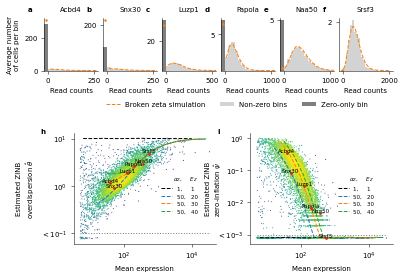

In [21]:
example_genes = ['Acbd4','Snx30', 'Luzp1','Papola','Naa50','Srsf3']
with mpl.rc_context(PAPER_CONTEXT):
    
    nrows = 4
    ncols = 6
    figheight_in = PAGEWIDTH_IN/ncols * nrows
    nrows_grid = 8
    ncols_grid = 12
    fig = plt.figure(figsize=(PAGEWIDTH_IN,figheight_in))
    axes = [plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(0, col*2),          colspan=2,rowspan=2) for col in range(6)]
    ax1 = plt.subplot2grid(shape=(nrows_grid,ncols_grid),   loc=(4, 1), colspan=5,rowspan=4)
    ax2 = plt.subplot2grid(shape=(nrows_grid,ncols_grid),   loc=(4, 7), colspan=5, rowspan=4)

    low_lim_theta = 10**-1
    low_lim_psi = 10**-3
    kde=True
    n_bins=25
    
    
    #make a separate adata object for the single genes to highlight
    ad_single_genes = adata_single_cluster_filtered[:,example_genes].copy()
    sort_idx = np.argsort(ad_single_genes.var.gene_mean_withinCluster)
    ad_single_genes = ad_single_genes[:,sort_idx]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        ad_single_genes_simulated = simulate_matched_zeta(ad_single_genes,params_single_genes, infos_single_genes)
    
    #plot histogram panels for each highlighted gene
    single_gene_plot(ad_single_genes,ad_single_genes_simulated,
                     axes=axes, n_bins=n_bins,
                     lineplot_kwargs=dict(linestyle='--',linewidth=LINEWIDTH))  
    for i,ax in enumerate(axes):
        if i==0:
            ax.set_ylabel('Average number\nof cells per bin')
            ax.get_legend().remove()
        elif i==1:
            ax.legend(frameon=False,loc=(0,-0.75),ncol=3)
        else:
            ax.get_legend().remove()
        sns.despine(ax=ax)
        
        
        
        
    
    key='theta'    
    clip_for_plotting(adata_single_cluster_filtered,key=f'{key}s_fit',low_limit=low_lim_theta)
    xdata = adata_single_cluster_filtered.var['gene_mean_withinCluster']
    xmin=np.min(xdata)
    xmax=np.max(xdata)
    ax1.hlines(low_lim_theta,xmin,xmax,colors='tab:gray',linestyles=':',linewidths=LINEWIDTH)
    ydata = adata_single_cluster_filtered.var[f'{key}s_fit_clipped_jitter']
    if kde:
        c = compute_kde(x=xdata,y=ydata, xscale='log',yscale='log')
    else:
        c = 'tab:gray'
    ax1.scatter(xdata,ydata,s=POINTSIZE,linewidth=0,c=c,rasterized=True)    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    #lines
    for i,ad in enumerate(ads_simulation_fits):
        #setup legend 
        target_alpha=ad.uns["infos_zeta_param_set"]["target_alpha"]
        target_mean=ad.uns["infos_zeta_param_set"]["target_mean"]
        legend_label = fr'{target_mean}'
        scale_str=str(target_alpha)
        scale_str=f'{scale_str}, {(3-len(scale_str))*"  "}'
        legend_label = f'{scale_str}{legend_label}'
        
        include_idx = ad.var.gene_mean_withinCluster <= xmax
        ad_filtered = ad[:,include_idx].copy()
        
        clip_for_plotting(ad_filtered,key=f'{key}s_fit',low_limit=low_lim_theta)
        ax1.plot(ad_filtered.var.gene_mean_withinCluster,
                 ad_filtered.var.thetas_fit_clipped_jitter, 
                 linestyle='--',c=ad_filtered.uns['clustercolor'],lw=LINEWIDTH,
                 label=legend_label)
        
    #highlight points
    highlight_genes_with_clipping(adata_single_cluster_filtered,example_genes,ax1)

    
    
    
    
    
    
    
    key='inflation'
    
    clip_for_plotting(adata_single_cluster_filtered,key=f'{key}s_fit',low_limit=low_lim_psi)
    xdata = adata_single_cluster_filtered.var['gene_mean_withinCluster']
    xmin=np.min(xdata)
    xmax=np.max(xdata)
    ax2.hlines(low_lim_psi,xmin,xmax,colors='tab:gray',linestyles=':',linewidths=LINEWIDTH) 
    ydata = adata_single_cluster_filtered.var[f'{key}s_fit_clipped_jitter']
    if kde:
        c = compute_kde(x=xdata,y=ydata, xscale='log',yscale='log')
    else:
        c = 'tab:gray'
    ax2.scatter(xdata,ydata,s=POINTSIZE,linewidth=0,c=c,rasterized=True)    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    
    #lines
    for i,ad in enumerate(ads_simulation_fits):  
        #setup legend
        target_alpha=ad.uns["infos_zeta_param_set"]["target_alpha"]
        target_mean=ad.uns["infos_zeta_param_set"]["target_mean"]
        legend_label = fr'{target_mean}'
        scale_str=str(target_alpha)
        scale_str=f'{scale_str}, {(3-len(scale_str))*"  "}'
        legend_label = f'{scale_str}{legend_label}'
        
        include_idx = ad.var.gene_mean_withinCluster <= xmax
        ad_filtered = ad[:,include_idx].copy()
        
        clip_for_plotting(ad_filtered,key=f'{key}s_fit',low_limit=low_lim_psi)
        ax2.plot(ad_filtered.var.gene_mean_withinCluster,
                 ad_filtered.var.inflations_fit_clipped_jitter, 
                 linestyle='--',c=ad_filtered.uns['clustercolor'],lw=LINEWIDTH,
                label=legend_label)

        
    #highlight points
    highlight_genes_with_clipping(adata_single_cluster_filtered,example_genes,ax2,ykey='inflations_fit',low_lim=low_lim_psi)
    
    leg=ax1.legend(frameon=False,loc=(0.6,0.25),title=r'$\alpha_Z$,     $E_Z$',fontsize=LEGEND_FONTSIZE,title_fontsize=LEGEND_FONTSIZE)
    leg._legend_box.align = "right"
    leg=ax2.legend(frameon=False,loc=(0.6,0.25),title=r'$\alpha_Z$,     $E_Z$',fontsize=LEGEND_FONTSIZE,title_fontsize=LEGEND_FONTSIZE)
    leg._legend_box.align = "right"
    
    sns.despine(ax=ax1)
    sns.despine(ax=ax2)
    ax1.minorticks_off()
    ax2.minorticks_off()
    
    ax1.set_rasterization_zorder(0)
    ax2.set_rasterization_zorder(0)
    ax1.set_yticks(ticks=[10**-1,10**0,10**1],labels=[r'$<10^{-1}$',r'$10^0$',r'$10^1$'])
    ax2.set_yticks(ticks=[10**-3,10**-2,10**-1,10**0],labels=[r'$<10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$'])
    ax1.set_ylabel('Estimated ZINB\n' fr'overdispersion $\hat\theta$')
    ax1.set_xlabel('Mean expression')
    ax2.set_ylabel('Estimated ZINB\n' fr'zero-inflation $\hat\psi$',labelpad=-7)
    ax2.set_xlabel('Mean expression')
    
    for i,(ax,xlim,ytick) in enumerate(zip(axes,
                            [250,250,500,1000,1000,2000],
                            [200,200, 20,   5,   5,   2])):
        pad=xlim*0.08
        ax.set_xlim(-pad,xlim+pad)
        ax.set_xticks([0,xlim])
        if i==0:
            ax.set_yticks([0,ytick])
        else:
            ax.set_yticks([ytick])
    
    letters=['a','b','c','d','e','f',
             'h','i']
    x_corrections=[0,0,0, 0,0,0,
                   0.065,0.065]
    up_y=0.16
    lo_y=0.05
    y_corrections=[up_y,up_y,up_y, up_y,up_y,up_y,
                   lo_y,lo_y]
    for ax,letter,x_corr,y_corr in zip(axes+[ax1,ax2],letters,x_corrections,y_corrections):
        ax.text(LETTER_LOC_X+x_corr,LETTER_LOC_Y+y_corr,letter,transform=ax.transAxes,fontweight='bold')
        
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
            
    plt.tight_layout()
    fig.savefig('figures/main_tasic_vs_simulated_readcounts.pdf', dpi=300, format=None,bbox_inches='tight')